In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.utils.data as td

## Preprocesamiento de datos

In [2]:
# PREPOCESAMIENTO DE DATOS


# cargar dataset
df_part = pd.read_csv('../data/todos_partidos.csv')
df_part.set_index('Match_ID', inplace=True)

# seleccionar variables de interes
df_1 = df_part.copy()
variables = df_1.drop(['Nombre_Eq1', 'Nombre_Eq2', 'Gol_Match_Eq1', 'Gol_Match_Eq2'], axis=1).columns.to_list()
df_1 = df_1[variables]


# ampliar dataset (x4) para ML
df_3 = df_1.copy()
for _ in range(2):
    df_3 = pd.concat([df_3, df_3], axis=0)

print('DATOS LISTOS')
print()


# DIVIDIR TEST Y TRAIN
df_4 = df_3.copy()
win_classes = {0:'Empate', 1:'Equipo_1', 2:'Equipo_2'}
caracteristicas = df_4.drop(['GANADOR'], axis=1).columns.to_list()
objetivo = 'GANADOR'

# dividir 70%-30% en entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(df_4[caracteristicas].values,
                                                    df_4[objetivo].values,
                                                    test_size=0.25,
                                                    random_state=42)

# normalizar catacteristicas
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

print('DATOS TEST Y TRAIN LISTOS')
print()


# PYTORCH
# Set random seed for reproducability
torch.manual_seed(0)

# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train_sc).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20, 
    shuffle=True, num_workers=1)  #True

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test_sc).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=True, num_workers=1)




DATOS LISTOS

DATOS TEST Y TRAIN LISTOS



## Red Neuronal

In [3]:
# DEFINIR LA RED NEURONAL

# nodos ocultos
hl = 10

# defnir la clase de la red
class ChampionsNet(nn.Module):
    def __init__(self):
        super(ChampionsNet, self).__init__()
        self.fc1 = nn.Linear(len(caracteristicas), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(win_classes))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x


def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feed forward
        optimizer.zero_grad()
        out = model(data)
        # loss = t.nn.functional.cross_entropy(out, target)
        loss = loss_criteria(out, target) #
        train_loss += loss.item() #

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           

def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()
            # test_loss += t.nn.functional.cross_entropy(out, target, reduction='sum').item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            #_, pred = t.max(out.data, 1)
            #correct += t.sum(target == pred).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

loss_criteria = nn.CrossEntropyLoss()

In [4]:
# EVALUACIÓN

def get_loss_graph(epoch_nums, training_loss, validation_loss):
    # gráfica de loss en training y validation a lo largo de los epochs
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()


def get_evaluation_metrics(model, x_test, y_test):
    '''
    - classification report
    - confusion matrix
    '''
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # No hay necesidad de rastrear gradientes ya que no estamos en fase de entrenamiento
    with torch.no_grad():
        # Convertir los datos de prueba a tensores de PyTorch
        test_x = torch.Tensor(x_test).float()
        test_y = torch.Tensor(y_test).long()
        
        # Realizar predicciones
        outputs = model(test_x)
        _, predicted = torch.max(outputs, 1)
        
        # Convertir predicciones y etiquetas verdaderas a arrays de numpy
        predicted_np = predicted.numpy()
        actual_np = test_y.numpy()
        
        # CLASSIFICATION REPORT
        class_report = classification_report(actual_np, predicted_np, target_names=list(win_classes.values()))
        print("Classification Report:\n", class_report)
        
        # CONFUSION MATRIX
        cm = confusion_matrix(y_test, predicted_np)
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(win_classes))
        plt.xticks(tick_marks, list(win_classes.values()), rotation=45)
        plt.yticks(tick_marks, list(win_classes.values()))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()


Epoch: 1
Training set: Average loss: 1.073977
Validation set: Average loss: 1.036688, Accuracy: 108/221 (49%)

Epoch: 2
Training set: Average loss: 1.001906
Validation set: Average loss: 0.975768, Accuracy: 125/221 (57%)

Epoch: 3
Training set: Average loss: 0.927836
Validation set: Average loss: 0.843044, Accuracy: 126/221 (57%)

Epoch: 4
Training set: Average loss: 0.876465
Validation set: Average loss: 0.849991, Accuracy: 134/221 (61%)

Epoch: 5
Training set: Average loss: 0.830517
Validation set: Average loss: 0.830509, Accuracy: 137/221 (62%)

Epoch: 6
Training set: Average loss: 0.814139
Validation set: Average loss: 0.824251, Accuracy: 140/221 (63%)

Epoch: 7
Training set: Average loss: 0.794444
Validation set: Average loss: 0.758285, Accuracy: 136/221 (62%)

Epoch: 8
Training set: Average loss: 0.789294
Validation set: Average loss: 0.870494, Accuracy: 138/221 (62%)

Epoch: 9
Training set: Average loss: 0.765896
Validation set: Average loss: 0.723178, Accuracy: 144/221 (65%)

E

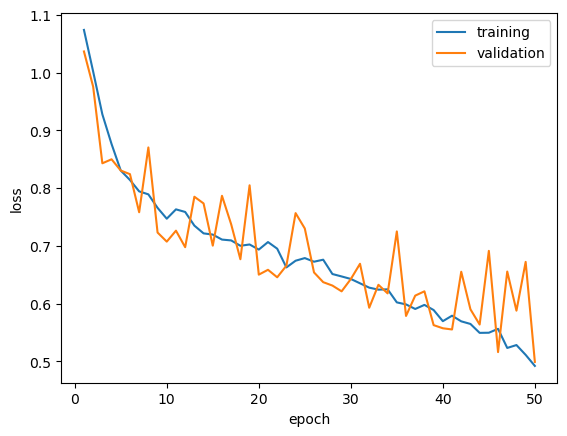

c:\Users\velir\anaconda3\envs\IA_UCL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\velir\anaconda3\envs\IA_UCL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\velir\anaconda3\envs\IA_UCL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

      Empate       0.00      0.00      0.00        45
    Equipo_1       0.49      0.93      0.64       103
    Equipo_2       0.46      0.15      0.23        73

    accuracy                           0.48       221
   macro avg       0.32      0.36      0.29       221
weighted avg       0.38      0.48      0.37       221



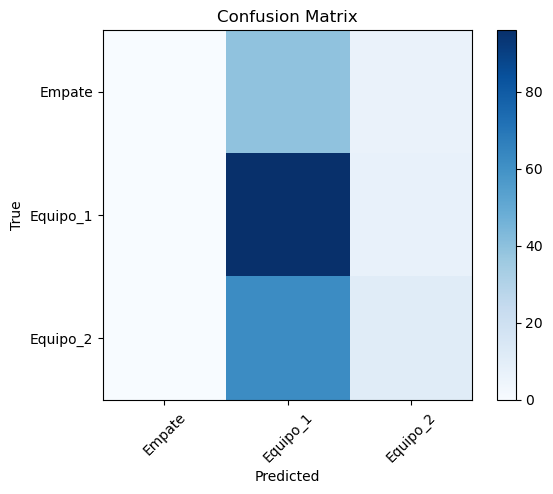

In [5]:
# ENTRENAMIENTO DE LA RED

# instancia de la red
model = ChampionsNet()
# loss function para clasificación multiclase
loss_criteria = nn.CrossEntropyLoss()

# optimizador 'Adam'
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# métricas de interés de los epochs
epoch_nums = []
training_loss = []
validation_loss = []

# Entrenamiento de la red
epochs = 50
for epoch in range(1, epochs+1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


print('ENTRNAMIENTO COMPLETADO')
print()

# EVALUACIÓN DEL MODELO
get_loss_graph(epoch_nums, training_loss, validation_loss)
get_evaluation_metrics(model, x_test, y_test)

## Enfrentamientos

In [6]:
def predecir_ganador(modelo, x_new):
    # Poner el modelo en modo de evaluación
    modelo.eval()
    
    # Convertir los datos de entrada a un tensor de PyTorch y predecir
    with torch.no_grad(): # No es necesario calcular gradientes
        x_tensor = torch.Tensor(x_new).float()
        outputs = modelo(x_tensor)
        _, predicted = torch.max(outputs.data, 1)
    
    # Recuperar el nombre de la clase ganadora
    prediccion = win_classes[predicted.item()]
    
    return prediccion


In [7]:
# Save the model weights
model_file = 'dnn_1_classifier.pth'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as dnn_1_classifier.pth


In [8]:
model = ChampionsNet()
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

### Octavos de final

In [9]:
#PSG-REAL SOCIEDAD
psg = [1.62,1.13,2.75,1.37,2.5,28.75,2.5,16.12,5.12,0.32,0.09,0.27,1.13,0.75,36]  # Equipo 1
real_soc = [1.0,0.62,1.62,1.0,1.62,23.37,1.5,13.25,4.25,0.32,0.08,0.24,0.75,0.76,25]  # Equipo 2

oct_p1 = [psg + real_soc]
print( predecir_ganador(model, oct_p1) )

Equipo_1


In [10]:
napoli = [1.29,0.57,1.86,1.14,1.71,24.86,2.29,13.43,4.0,0.3,0.09,0.29,1.43,0.71,35]
barca = [1.71,1.71,3.43,1.71,3.43,27.29,3.0,16.0,5.14,0.32,0.11,0.33,1.0,0.68,22]

oct_p2 = [napoli + barca]
print( predecir_ganador(model, oct_p2) )

Equipo_1


In [11]:
man_city = [2.38,1.77,4.15,2.23,4.0,28.08,4.0,15.08,6.54,0.43,0.15,0.34,0.38,0.89,37]
copenh = [1.25,0.75,2.0,1.13,1.87,18.25,2.12,10.25,3.25,0.32,0.11,0.35,1.75,0.7,44]

oct_p3 = [copenh + man_city]
print( predecir_ganador(model, oct_p3) )

Equipo_1


In [12]:
atl_mad = [2.14,1.29,3.43,2.14,3.43,23.86,3.14,12.71,4.43,0.35,0.17,0.48,1.0,0.77,31]
inter = [1.29,0.71,2.0,0.86,1.57,25.86,2.0,14.43,4.14,0.29,0.06,0.21,0.71,0.8,25]

oct_p4 = [atl_mad + inter]
print( predecir_ganador(model, oct_p4) )

Equipo_1


In [13]:
dortmund = [1.14,1.0,2.14,1.0,2.0,23.0,2.14,13.0,4.43,0.34,0.08,0.23,0.71,0.89,26]
psv = [1.14,0.71,1.86,0.86,1.57,28.43,2.14,15.29,5.0,0.33,0.06,0.17,1.57,0.59,27]

oct_p5 = [dortmund + psv]
print( predecir_ganador(model, oct_p5) )

Equipo_1


In [14]:
bay_munch = [1.87,1.5,3.38,1.75,3.25,27.87,3.12,15.37,4.37,0.28,0.11,0.4,0.87,0.77,22]
lazio = [1.0,0.62,1.62,0.75,1.37,20.62,1.75,11.37,3.25,0.29,0.07,0.23,1.25,0.68,31]

oct_p6 = [bay_munch + lazio]
print( predecir_ganador(model, oct_p6) )

Equipo_1


In [15]:
arsenal = [2.29,1.86,4.14,2.14,4.0,22.0,3.86,12.29,4.43,0.36,0.17,0.48,0.71,0.75,20]
porto = [2.29,1.71,4.0,2.14,3.86,23.71,3.57,13.29,6.0,0.45,0.16,0.36,1.14,0.67,24]

oct_p7 = [arsenal + porto]
print( predecir_ganador(model, oct_p7) )

Equipo_1


In [16]:
real_mad = [2.12,1.87,4.0,2.12,4.0,34.75,4.12,18.62,6.0,0.32,0.11,0.35,1.0,0.8,35]
lepizig = [1.75,1.62,3.38,1.75,3.38,27.87,3.38,15.5,5.12,0.33,0.11,0.34,1.5,0.6,30]

oct_p8 = [real_mad + lepizig]
print( predecir_ganador(model, oct_p8) )

Equipo_1
